### Problem Description

We are provided with the dataset with over 11 000 properties in NYC with their energy consumption/efficiency properties. Our main point of interest is Energy Star Score, which is an aggregate measure (ranging from 0 to 100) of the overall energy efficiency of a building. Many buildings are missing this score, and we want to predict it using machine learning algorithms. 

Documentation of the column names can be found in [this document](http://www.nyc.gov/html/gbee/downloads/pdf/2016_nyc_benchmarking_data_disclosure_definitions.pdf).

### The Approach

This project consists of the following steps:

1. Loading the data in and doing some preliminary data cleaning
2. Performing exploratory data analysis by visualizing the data
3. Building a simpler model by removing higly correlated features
4. Preprocessing data for regression implementation
5. Implementing various regression models to make predictions and comparing the results
6. Improving model performace using hyperparameter tuning
7. Preprocessing data for the classification by binning the numerical values
7. Trying out different classification models to make predictions and comparing the results

### Import the Dataset

First we will import some important Python libraries and examine the dataset a bit.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('../Energy_and_Water_Data_Disclosure.csv')
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,...,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,...,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,Not Available,...,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.841559,-73.942528,12.0,10.0,255.0,Washington Heights South ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

### Data Cleaning

We see that there are many `Not Available` instances (which machine considers actually as present), and that some features that should be considered as numerical are not. Before doing any further data manipulation, we need to fix this. 

In [4]:
data = data.replace({'Not Available' : np.nan})

for col in data.columns:
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        data[col] = data[col].astype('float')

In [5]:
data = data.rename(columns = {'ENERGY STAR Score' : 'Score',
                      'Primary Property Type - Self Selected' : 'Building Type'})


### EDA

Let's explore how the Energy Star Score (ESS) is distributed first.

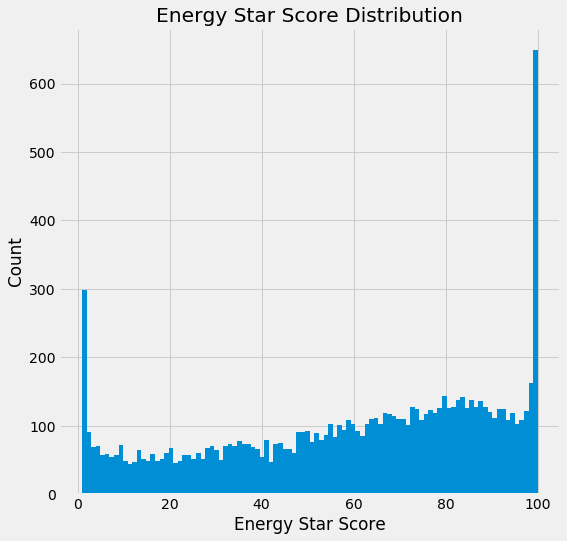

In [6]:
figsize(8,8)

plt.hist(data['Score'].dropna(), bins = 100);
plt.xlabel('Energy Star Score'), plt.ylabel('Count');
plt.title('Energy Star Score Distribution');

We see the number of 100 ESS buldings towering above all others. Is the NYC so energy efficient? We can be sure it isn't, but what makes this count so high is the fact that the ESS is self-reported, so there's a big chance that many property owners reported their score falsely. 

Another important measure of the energy efficiency is 'Weather Normalized Site EUI (kBtu/ft²)'. EUI is short for Energy Star Score. It is straightforward to calculate: take the total annual energy use (in kBtu) and divide by the square footage of the building. The EUI is meant for normalized energy use comparisons between buildings of the same building type. This measure is likely more objective than ESS because it uses actual measure consumption. Let's check it's distribution. 

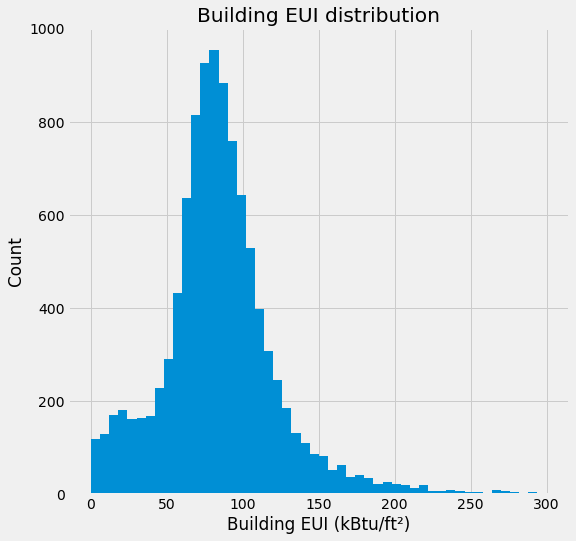

In [7]:
figsize(8,8)

plt.hist(data['Weather Normalized Site EUI (kBtu/ft²)'].dropna(),
        bins = 50, range = (0,300));
plt.xlabel('Building EUI (kBtu/ft²)'); plt.ylabel('Count');
plt.title('Building EUI distribution');

Now let's check how ESS and EUI distributions vary accross different building types. We'll take only the most common building types into the consideration.

The kernel density plot x-limits do extend beyond the range of actual scores because of the kernel density estimation method used to make the probability density distribution. The actual values in a density plot can be difficult to interpret, and it is more instructive to focus on the distribution/shape of the figure.

In [8]:
types = data.dropna(subset = ['Score'])
types = types['Building Type'].value_counts() > 80
types = types[types.values].index

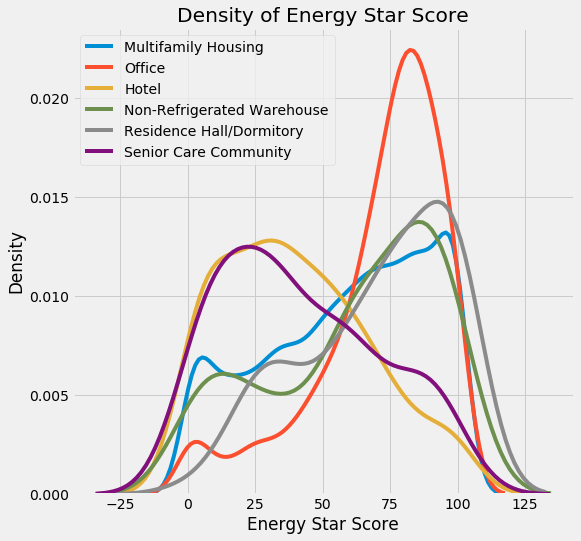

In [9]:
for b_type in types:
    
    sub_data = data[data['Building Type'] == b_type]
    
    sns.kdeplot(sub_data['Score'].dropna(),
               label = b_type)
    
plt.xlabel('Energy Star Score'), plt.ylabel('Density');
plt.title('Density of Energy Star Score');

We can conclude that office buildings tend to have much higher Energy Star Scores than hotels and senior care communities. Residence halls and non-refrigerated warehouses have higher scores as well.


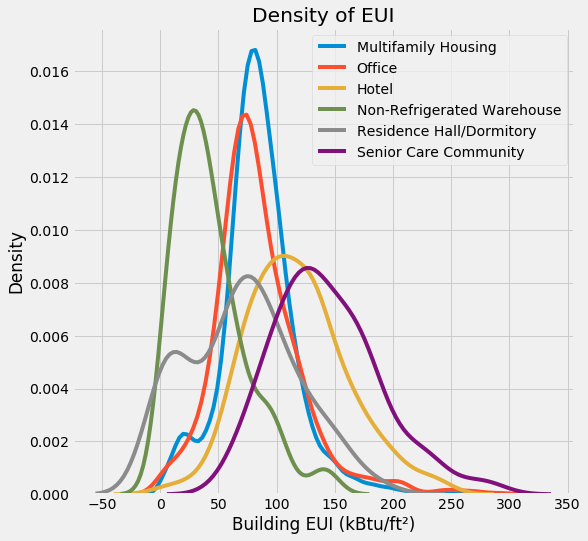

In [10]:
for b_type in types:
    
    sub_data = data[(data['Building Type'] == b_type)
                   & (data['Weather Normalized Site EUI (kBtu/ft²)'] < 300)]
    
    sns.kdeplot(sub_data['Weather Normalized Site EUI (kBtu/ft²)'].dropna(),
                         label = b_type)
    
plt.xlabel('Building EUI (kBtu/ft²)'), plt.ylabel('Density');
plt.title('Density of EUI');    

There appears to be a negative correlation between the Site EUI and the Energy Star Score based on comparing the two distributions between building types. Building types with lower EUI tend to have higher ESS. We can visualize the relationship between the ESS and the EUI in a scatterplot.

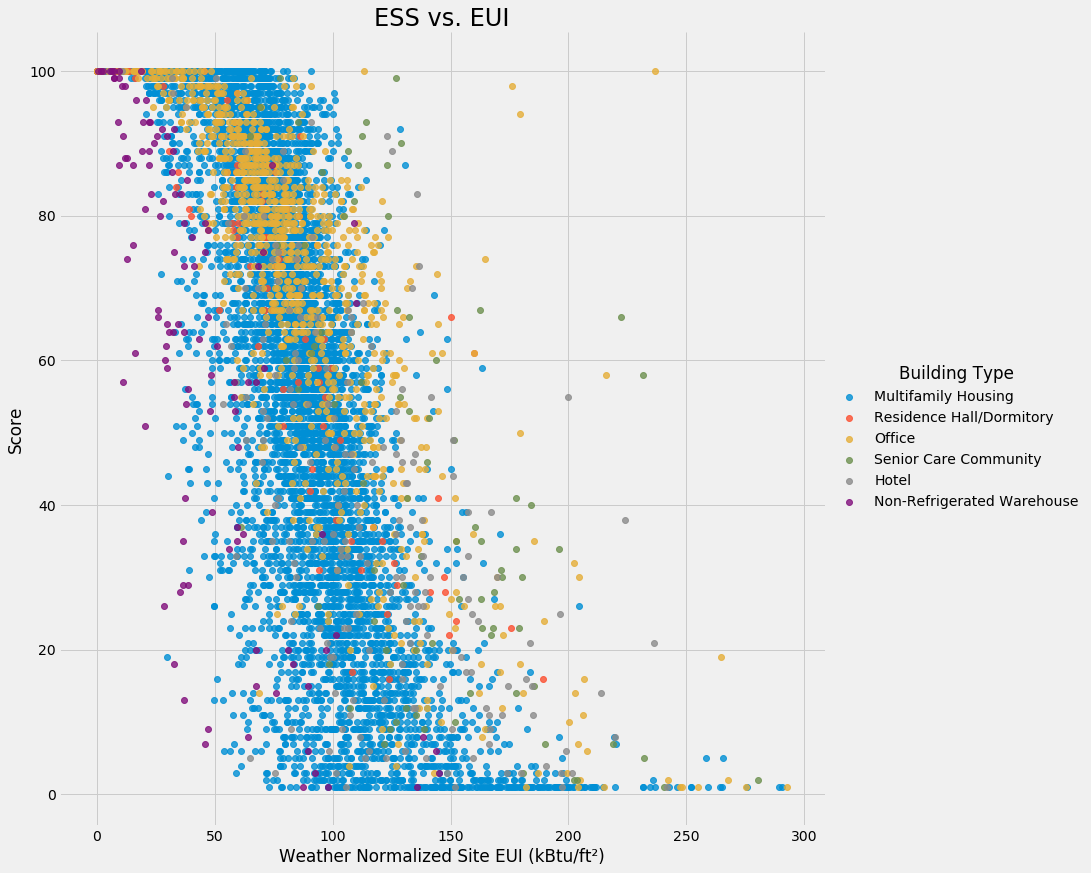

In [11]:
sub_data = data[(data['Weather Normalized Site EUI (kBtu/ft²)'] < 300)
               & (data['Building Type'].isin(types))]

sns.lmplot('Weather Normalized Site EUI (kBtu/ft²)', 'Score',
          data = sub_data, height = 12, hue = 'Building Type',
          fit_reg = False);
plt.title('ESS vs. EUI', size = 24);

It seems that the negative correlation really holds between the ESS and the EUS. It also looks like it holds across the building types.  

### Linear Correlations with the Energy Star Score

We want now to compare some of the features with the ESS, and how they are correlated with it.

In [12]:
features = ['Building Type',
            'Weather Normalized Site EUI (kBtu/ft²)',
            'Weather Normalized Site Electricity Intensity (kWh/ft²)',
             'Largest Property Use Type - Gross Floor Area (ft²)',
            'Natural Gas Use (kBtu)',
            'Score']

#filtering data
sub_data = data[features].dropna()
sub_data = sub_data[(sub_data['Building Type'].isin(types))
                   & (sub_data['Weather Normalized Site EUI (kBtu/ft²)'] < 300)]

#renaming the columns
sub_data.columns = ['Building Type',
            'Site EUI',
            'Electricity Intensity',
             'Floor Area',
            'Natural Gas Use',
            'Score']

In [13]:
corrs = sub_data.groupby('Building Type').corr()
corrs = pd.DataFrame(corrs['Score'])
corrs

Score
Building Type                                             
Hotel                      Site EUI              -0.598284
                           Electricity Intensity -0.553256
                           Floor Area             0.042204
                           Natural Gas Use       -0.097727
                           Score                  1.000000
Multifamily Housing        Site EUI              -0.743034
                           Electricity Intensity -0.602274
                           Floor Area            -0.007159
                           Natural Gas Use       -0.168528
                           Score                  1.000000
Non-Refrigerated Warehouse Site EUI              -0.726648
                           Electricity Intensity -0.719545
                           Floor Area             0.125143
                           Natural Gas Use       -0.221939
                           Score                  1.000000
Office                     Site EUI              -0.784825
                           Electricity Intensity -0.705143
                           Floor Area             0.041398
                           Natural Gas Use       -0.141701
                           Score                  1.000000
Residence Hall/Dormitory   Site EUI              -0.876173
                           Electricity Intensity -0.727305
                           Floor Area            -0.071806
                           Natural Gas Use       -0.391847
                           Score                  1.000000
Senior Care Community      Site EUI              -0.566617
                           Electricity Intensity -0.572131
                           Floor Area             0.105373
                           Natural Gas Use       -0.283634
                           Score                  1.000000

We see that the ESS is strongly negatively correlated with the Electricity Intensity and the EUI. Nnatural gas usage tends to be negatively correlated with the ESS as well. The relationship between floor area and the ESS is weak for all building types.

### Removing Collinear Features

To simplify our model and make it more efficient, we will search for features which are highly correlated, and then include in the model only those features that do not have high correlation coefficient. We consider features to be highly correlated if their correlation coeficient is higher than 0.5. For example, `Site EUI` and `Weather Normalized Site EUI` are very highly correlated (nearly 1.0) and therefore we only need to include one of these measures in our model.

In [14]:
new_data = data.drop(columns = ['Score'])

In [15]:
#Matrix of all correlations
corr_matrix_df = new_data.corr()
corr_matrix = np.array(corr_matrix_df)
#making the matrix upper diagonal, so we can see which columns to drop out
corr_matrix = np.triu(corr_matrix,1)

In [16]:
#obtaining the columns which we can drop
drop_cols = list(set(np.where(abs(corr_matrix) >= 0.5)[1]))
drop_cols = list(corr_matrix_df.iloc[:,drop_cols].columns)

c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


In [17]:
#dropping the columns
new_data = new_data.drop(columns = drop_cols)
new_data['Score'] = data['Score']

In [18]:
print('Old Data Shape:', data.shape)
print('New Data Shape with correlated features removed', new_data.shape)

Old Data Shape: (11746, 60)
New Data Shape with correlated features removed (11746, 39)


### Regression Preprocessing

We will create a function that preprocesses the obtained dataframe in one go: it will encode the categorical variables, throw out the unnecessary ones, impute the missing values, and do the train-test split.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [20]:
def train_test_reg(df):
    
    #First, we select all the numerical variables
    X = df.select_dtypes('number')
    
    #Then we add in the important categorical variables
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status']    
    #and encode them to dummy variables
    X = pd.get_dummies(X)
    
    #We take out those entries that have missing ESS
    miss_score_entries = X[X['Score'].isnull()]
    #and keep only those entries that have ESS
    X = X.dropna(subset = ['Score'])
    
    #Creating the vector of dependent variables
    y = X['Score']
    #and throwing out some numerical variables to creat matrix of features
    X = X.drop(columns = ['Order', 'Property Id', 'Score'])
    
    miss_score_entries = miss_score_entries.drop(columns = ['Order', 'Property Id', 'Score'])
    
    #We will use feature names for the future reference
    features = list(X.columns)
    
    
    #Splitting into the train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.25,
                                                       random_state = 19)
    
    
    #Imputing the missing values
    imputer = SimpleImputer(strategy = 'median')

    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    miss_score_entries = imputer.transform(miss_score_entries)
    
    #Scaling the values
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    miss_score_entries = scaler.transform(miss_score_entries)
    
    return X_train, X_test, y_train, y_test, miss_score_entries, features

In [21]:
X_train, X_test, y_train, y_test, miss_score_entries, features = train_test_reg(new_data)
print('Train set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Train set shape: (7231, 74)
Test set shape: (2411, 74)


c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Regression Baseline

First we will establish a regression baseline: the mean absolute error between the `y_test` points and average of the `y_train` values. This is the most rudamentary regression model, and our model will have to beat it considerably.  

In [22]:
baseline = np.mean(y_train)

base_err = np.mean(abs(baseline - y_test))
print('Regression base error: {:0.2f}'.format(base_err))

Regression base error: 26.10


### Linear Regression

Now let's try out the simple linear regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_err = mean_absolute_error(lin_reg_pred, y_test)
print('Linear regression error: {:0.2f}'.format(lin_reg_err))

Linear regression error: 24.96


### Random Forest Regression

Linear regression performs quite poorly. So, we have to resort to some other algorithms. Now we'll try out the random forest regressor.

In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200, n_jobs = -1)

forest_reg.fit(X_train, y_train)
forest_reg_pred = forest_reg.predict(X_test)
forest_reg_err = mean_absolute_error(forest_reg_pred, y_test)
print('Random forest regression error: {:0.2f}'.format(forest_reg_err))

Random forest regression error: 9.22


This is much better than the linear regressor! Let's check out the $R^2$ score of the random forest regressor.

In [25]:
r_sq = np.corrcoef(forest_reg_pred,y_test)[0,1]
print('R^2 score for random forest regression: {:0.2f}'.format(r_sq))

R^2 score for random forest regression: 0.90


That's a pretty good $R^2$ score (but it can also imply the overfitting). And now let's move onto the interpretation of the regression results.

### Regression Results Interpretation

First, let's compare the predicted values with the true values of the test set. 

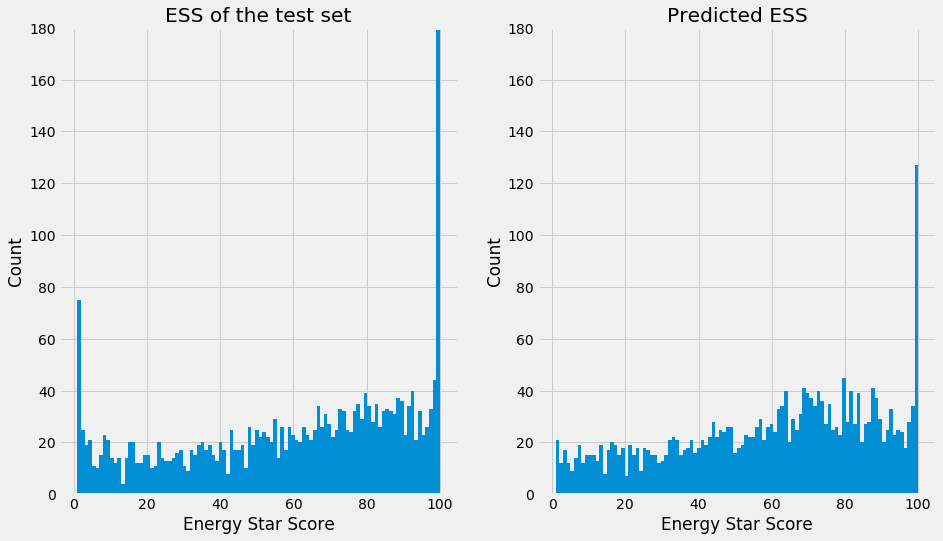

In [26]:
figsize(14, 8)

ax = plt.subplot(121)
ax.hist(y_test, bins = 100);
ax.set_xlabel('Energy Star Score'), ax.set_ylabel('Count');
ax.set_ylim(0,180)
ax.set_title('ESS of the test set');

ax1 = plt.subplot(122)
ax1.hist(forest_reg_pred, bins = 100);
ax1.set_xlabel('Energy Star Score'), ax1.set_ylabel('Count');
ax1.set_ylim(0,180)
ax1.set_title('Predicted ESS');

We see that current model predicts test data nicely. Moreover, it evens out the data, by reducing the number of buildings having 0 and 100. This gives more realistic pictures since, given the fact that ESS is self-reported, we can consider those buildings gave either wrong or misscalculated data. 

Now we can use the model to generate new predictions for the buildings with missing scores.

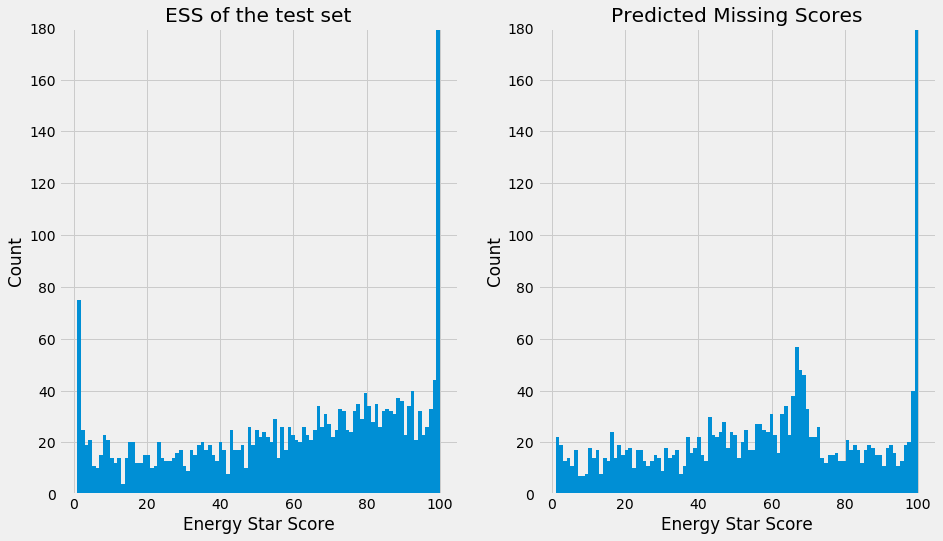

In [27]:
miss_score_pred = forest_reg.predict(miss_score_entries)

figsize(14, 8)

ax = plt.subplot(121)
ax.hist(y_test, bins = 100);
ax.set_xlabel('Energy Star Score'), ax.set_ylabel('Count');
ax.set_ylim(0,180)
ax.set_title('ESS of the test set');

ax1 = plt.subplot(122)
ax1.hist(miss_score_pred, bins = 100);
ax1.set_xlabel('Energy Star Score'), ax1.set_ylabel('Count');
ax1.set_ylim(0,180)
ax1.set_title('Predicted Missing Scores');

Even though it has amazing $R^2$ socre, it seems that this model predicted a bit too many buildings with 100 ESS. We'll try to see if there's a way to remedy this. 

Let's explore the features that influence our random forest regression model the most. 

In [28]:
def feature_importance(features, importances):
    
    #Creating a dataframe that will list out features and their importance factors
    features_df = pd.DataFrame({'features':features,
                'importances':importances})
    features_df = features_df.sort_values('importances', ascending = False)
    
    #Throwing out insignificant features
    x_ax = features_df[features_df['importances'] > 0.01]['features']
    y_ax = features_df[features_df['importances'] > 0.01]['importances']
    
    figsize(8,8)
    plt.bar(x_ax, y_ax);
    plt.xlabel('features'), plt.ylabel('importances');
    plt.xticks(rotation = 90);
    plt.title('Top Feature Importances');
    plt.show();
    
    return features_df

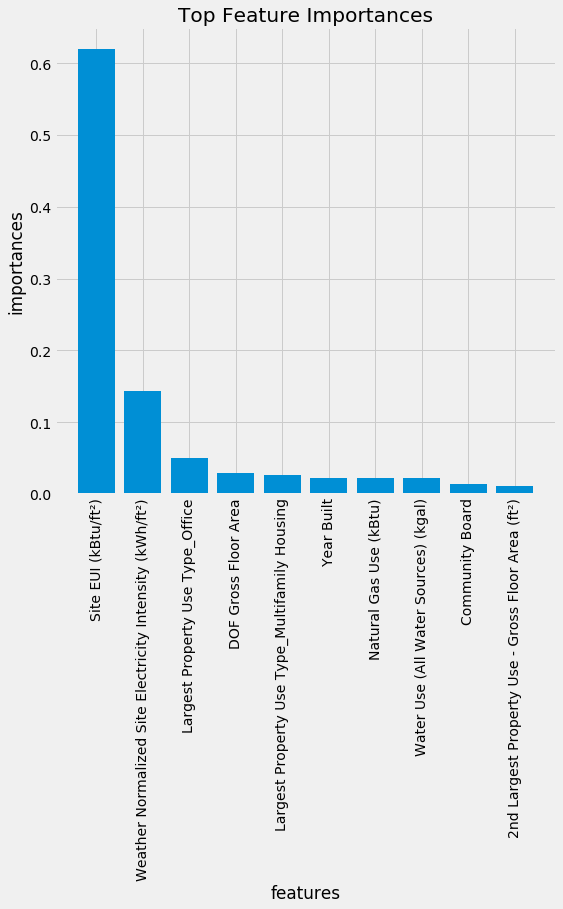

In [29]:
features_df = feature_importance(features,forest_reg.feature_importances_)

In [30]:
features_df.head(10)

,features,importances
5,Site EUI (kBtu/ft²),0.619217
6,Weather Normalized Site Electricity Intensity ...,0.142736
37,Largest Property Use Type_Office,0.050331
0,DOF Gross Floor Area,0.028321
34,Largest Property Use Type_Multifamily Housing,0.025759
2,Year Built,0.022293
10,Natural Gas Use (kBtu),0.022096
11,Water Use (All Water Sources) (kgal),0.021401
12,Community Board,0.013671
1,2nd Largest Property Use - Gross Floor Area (ft²),0.011208


We see that `Site EUI` feature outrangs all the rest by far. And we already saw that it is higly correlated with the Energy Score. Maybe throwing it out will give us a better model?

In [31]:
new_data = new_data.drop(columns = ['Site EUI (kBtu/ft²)'])

### Random Forest Regression, take 2

Now we'll implement the random forest regression once again, but for the dataset with the `Site EUI` feature thrown out. 

In [32]:
X_train, X_test, y_train, y_test, miss_score_entries, features = train_test_reg(new_data)
print('Train set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Train set shape: (7231, 73)
Test set shape: (2411, 73)


c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [33]:
#Training a new regressor
forest_reg = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
forest_reg.fit(X_train,y_train)
forest_reg_pred = forest_reg.predict(X_test)

In [34]:
forest_reg_err =  mean_absolute_error(forest_reg_pred,y_test)
print('Random forest regression error: {:0.2f}'.format(forest_reg_err))

r_sq = np.corrcoef(forest_reg_pred,y_test)[0,1]
print('R^2 score for random forest regression: {:0.2f}'.format(r_sq))

Random forest regression error: 13.55
R^2 score for random forest regression: 0.80


$R^2$ score is smaller for this model, but let's visualize how it performs.

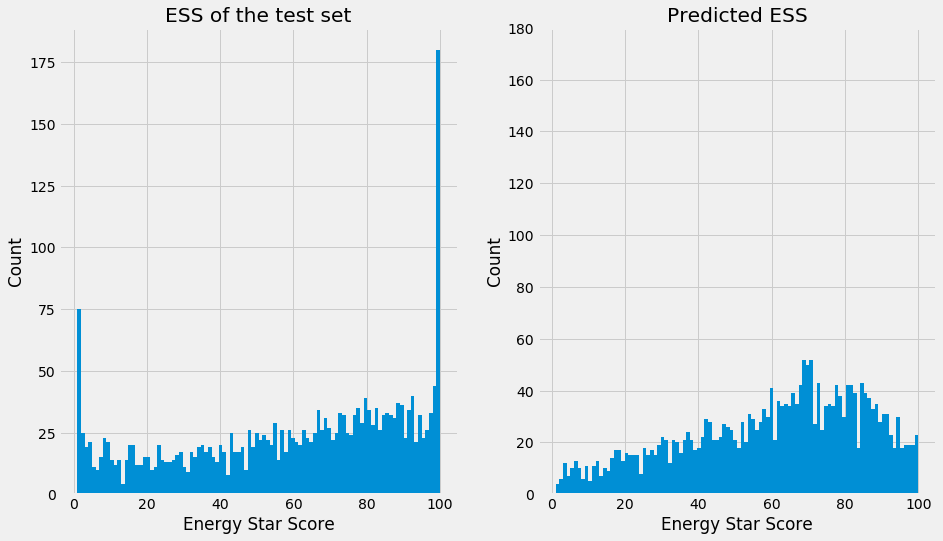

In [35]:
figsize(14,8)

ax = plt.subplot(121)
ax.hist(y_test, bins = 100);
ax.set_xlabel('Energy Star Score'), ax.set_ylabel('Count');
ax.set_title('ESS of the test set');

ax1 = plt.subplot(122)
ax1.hist(forest_reg_pred, bins = 100);
ax1.set_xlabel('Energy Star Score'), ax1.set_ylabel('Count');
ax1.set_ylim(0,180);
ax1.set_title('Predicted ESS');

Even though it's less precise than the first model, the new model handles the extreme energy scorse even better, by redistributing them even better. Moreover, the predicted values in the new model do resemble a normal distribution, which is certainly closer to the real state of affair. 

Now let's use the new model to predict the missing values.

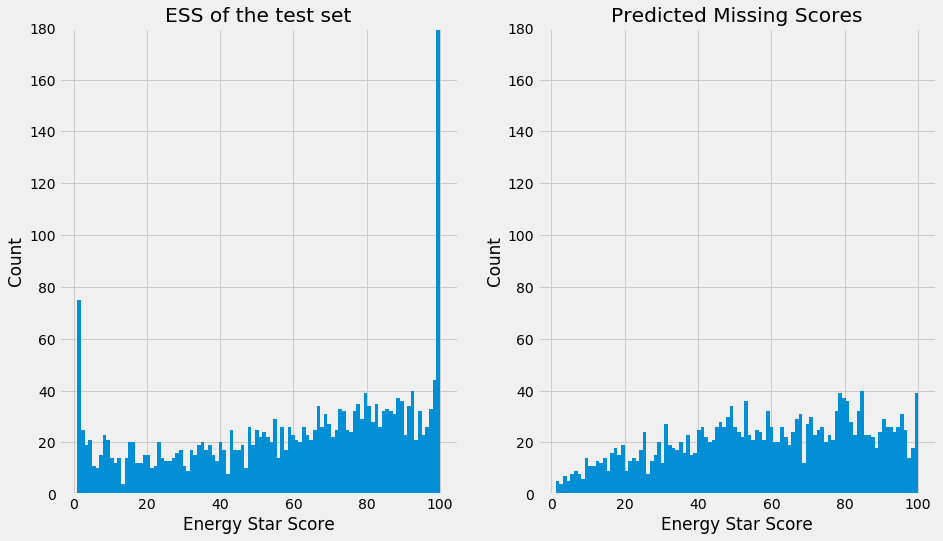

In [36]:
miss_score_pred = forest_reg.predict(miss_score_entries)


figsize(14,8)

ax = plt.subplot(121)
ax.hist(y_test, bins = 100);
ax.set_ylim(0,180)
ax.set_xlabel('Energy Star Score'), ax.set_ylabel('Count');
ax.set_title('ESS of the test set');

ax1 = plt.subplot(122)
ax1.hist(miss_score_pred, bins = 100);
ax1.set_xlabel('Energy Star Score'), ax1.set_ylabel('Count');
ax1.set_ylim(0,180);
ax1.set_title('Predicted Missing Scores');

Since it's more precise than the second one, we can use the first model to predict the unknown values, and use the second one to calculate the real energy scores for those that seem fake or misscalculated. Also, switching completely to the new model wouldn't be a bad decision at all.

Next thing, let's see how the features are rated by their importance in this new model.

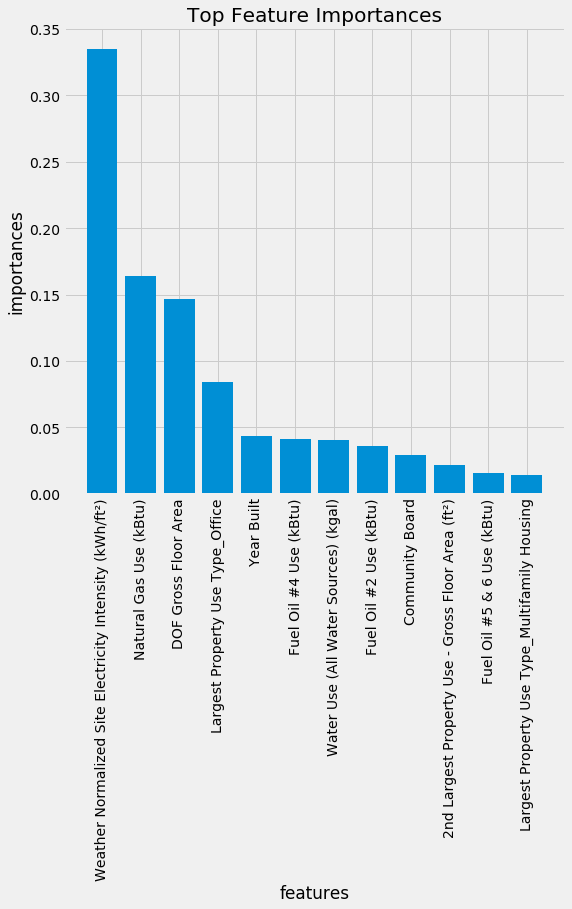

In [37]:
features_df = feature_importance(features,forest_reg.feature_importances_)

In [38]:
features_df.head(10)

,features,importances
5,Weather Normalized Site Electricity Intensity ...,0.334592
9,Natural Gas Use (kBtu),0.163737
0,DOF Gross Floor Area,0.147013
36,Largest Property Use Type_Office,0.083844
2,Year Built,0.043870
7,Fuel Oil #4 Use (kBtu),0.040903
10,Water Use (All Water Sources) (kgal),0.040738
6,Fuel Oil #2 Use (kBtu),0.035750
11,Community Board,0.028843
1,2nd Largest Property Use - Gross Floor Area (ft²),0.021805


It's obvious that the electricity use dominates the other factors, but the situation is not as problematic with the EUI in the first model. In addition, we see that natural gas and fuel oil use, floor area and year built can be considered as important features. 

### Other Regression Models 

We will use several more regression models, and compare their performance. 

In [39]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [40]:
#Defining a function for utilizing our regression models
def fit_and_evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = mean_absolute_error(y_test, y_pred)
    
    return err

In [41]:
#Support Vector Machine (SVM) Regressor
svr = SVR(C = 1000, gamma = 0.1)

svr_err = fit_and_evaluate(svr, X_train, y_train, X_test, y_test)
print('Support vector regressor error: {:0.2f}'.format(svr_err))

Support vector regressor error: 24.52


In [42]:
#Gradient Boosting Regressor
g_boost = GradientBoostingRegressor()

g_boost_err = fit_and_evaluate(g_boost, X_train, y_train, X_test, y_test)
print('Gradient boosting regressor error: {:0.2f}'.format(g_boost_err))

Gradient boosting regressor error: 15.05


In [43]:
#K-Nearest Neighbours Regressor
knn = KNeighborsRegressor(n_neighbors=10)

knn_err = fit_and_evaluate(knn, X_train, y_train, X_test, y_test)
print('KNN regressor error: {:0.2f}'.format(knn_err))

KNN regressor error: 24.28


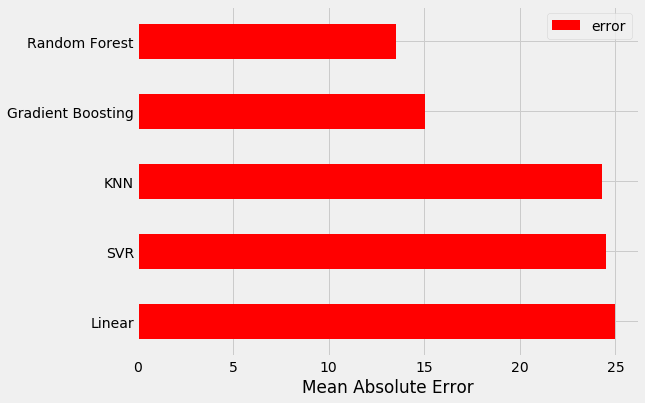

In [44]:
#Plotting the results
figsize(8,6)
err_table = pd.DataFrame({'model':['Linear', 'Random Forest', 'SVR', 'Gradient Boosting', 'KNN'],
                         'error':[lin_reg_err, forest_reg_err, svr_err, g_boost_err, knn_err]})
err_table = err_table.sort_values('error', ascending = False)


err_table.plot(x = 'model', y = 'error', kind = 'barh', color = 'red');

plt.ylabel(''); plt.xlabel('Mean Absolute Error');

We see that SVR and KNN are not performing that well on our setting. However, gradient boosting does give a nice result.

### Hyperparameter tuning

Now we will try to improve the performance of the gradient boosting regressor by doing the hyperparameter tuning. First we will do a randomized grid search, to see which hyperparameter values are more optimal, and then we'll do some fine-tuning around those values. 

In [45]:
#generating the grid
loss = ['ls','lad','huber']
n_estimators = [100, 500, 750, 1000, 1500]
min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8, 10]
max_depth = [2, 3, 5, 10, 15]
max_features = ['auto','sqrt','log2']

hyperparameter_grid = {'loss':loss, 'n_estimators':n_estimators,
                      'min_samples_split':min_samples_split,
                      'min_samples_leaf':min_samples_leaf,
                      'max_depth':max_depth,
                      'max_features':max_features}

In [46]:
#Setting up randomized grid search 
from sklearn.model_selection import RandomizedSearchCV

model = GradientBoostingRegressor(random_state=19)

rand_cv = RandomizedSearchCV(estimator=model,
                            param_distributions=hyperparameter_grid,
                            n_iter = 25, scoring = 'neg_mean_absolute_error',
                            n_jobs = -1, cv = 5, random_state=19,
                            return_train_score=True)

In [47]:
rand_cv.fit(X_train, y_train);

In [48]:
#Listing the best performing scores
rand_cv_scores = pd.DataFrame(rand_cv.cv_results_)
rand_cv_scores = rand_cv_scores.sort_values('mean_test_score', ascending = False)
rand_cv_scores[['mean_train_score','mean_test_score']].head(5)

,mean_train_score,mean_test_score
13,-6.339310,-12.628155
19,-5.825691,-12.726291
24,-5.431763,-12.778173
3,-6.990531,-12.834340
1,-5.679931,-12.842715


In [49]:
#Getting the best performing set of hyper-parameters
rand_cv.best_params_

{'n_estimators': 750,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 5,
 'loss': 'huber'}

Now we will tune `n_estimators` parameter using a grid search, while keeping the other parameter values fixed as above.

In [50]:
#Setting up the grid search
from sklearn.model_selection import GridSearchCV

tree_grid = {'n_estimators':[600, 650, 700, 750, 800]}


model = GradientBoostingRegressor(min_samples_leaf= 8,
                                 min_samples_split=2,
                                 max_features='auto',
                                 max_depth=5,
                                 loss = 'huber',
                                 random_state=19)

grid_cv = GridSearchCV(estimator = model, 
                      param_grid=tree_grid,
                      scoring = 'neg_mean_absolute_error',
                      n_jobs = -1, cv = 5,
                      return_train_score=True)

In [51]:
grid_cv.fit(X_train,y_train);

In [52]:
#Listing the best performing scores
grid_cv_scores = pd.DataFrame(grid_cv.cv_results_)
grid_cv_scores = grid_cv_scores.sort_values('mean_test_score',
                                           ascending = False)
grid_cv_scores[['param_n_estimators','mean_train_score','mean_test_score']].head(5)

,param_n_estimators,mean_train_score,mean_test_score
0,600,-6.921051,-12.618655
1,650,-6.724012,-12.621206
3,750,-6.339310,-12.628155
2,700,-6.519648,-12.630222
4,800,-6.157976,-12.647271


We see that having the 600 estimators give the best result. Having the mean absolute error of 12.62, we have managed to improve the gradient boosting algorithm to perform even better than the random forest regression!

Now we will try out the new and improved model to see how it performs on the test set.

In [55]:
final_model = grid_cv.best_estimator_
final_model.fit(X_train, y_train)
final_model_pred = final_model.predict(X_test)

In [57]:
final_model_err =  mean_absolute_error(final_model_pred,y_test)
print('Regression error of the final model: {:0.2f}'.format(final_model_err))

r_sq = np.corrcoef(final_model_pred,y_test)[0,1]
print('R^2 score for the final model: {:0.2f}'.format(r_sq))

Regression error of the final model: 12.71
R^2 score for the final model: 0.82


### Random Forest Classification

We will now try to use the random forest classification to place buildings into classes based on their energy scores. We will use a simple grading scheme where every 20 point interval is a grade, giving us 5 total ranks.

As with the regression, first we make a function that will preprocess our data for the classification in one go. We will also add back `Site EUI` feature back to our dataset. We can also build a model excluding it, which we could use to classify buildings that reporeted 0 or 100 energy score. 

In [62]:
new_data['Site EUI (kBtu/ft²)'] = data['Site EUI (kBtu/ft²)']

In [63]:
def train_test_class(df):
    
    #Selecting the numerical features
    X = df.select_dtypes('number')
    
    #Importing the important categorical features
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status']
    
    #Encoding the categories
    X = pd.get_dummies(X)
    
    #Setting out entries with missing energy score
    miss_score_entries = X[X['Score'].isnull()]
    X = X.dropna(subset = ['Score'])
    
    #Grouping energy scorse into five ranks
    y = pd.cut(X['Score'], bins = range(0,101,20),
              labels = ['F','D','C','B','A'])
    
    
    #Dropping unimportant numerical features
    X = X.drop(columns = ['Order', 'Property Id', 'Score'])
    miss_score_entries = miss_score_entries.drop(columns = ['Order', 'Property Id', 'Score'])
    
    
    #Doing the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size = 0.2,
                                                       random_state = 19)
    
    
    
    #Imputing the missing values
    imputer = SimpleImputer(strategy = 'median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    miss_score_entries = imputer.transform(miss_score_entries)
    
    return X_train, X_test, y_train, y_test, miss_score_entries

In [64]:
X_train, X_test, y_train, y_test, miss_score_entries = train_test_class(new_data)

c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\alegzander\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [65]:
train_vals = pd.Series(y_train).value_counts()
train_vals.sort_index(ascending = False)

A    2419
B    1821
C    1344
D    1008
F    1121
Name: Score, dtype: int64

The most common rank for buildings is A and the least common is F. The skew towards higher energy star scores is visible once again. 

And now we construct the random forest classifier.

In [66]:
from sklearn.ensemble import RandomForestClassifier

for_clf = RandomForestClassifier(n_estimators= 200, n_jobs=-1)
for_clf.fit(X_train, y_train)
for_clf_pred = for_clf.predict(X_test)

To check the performance of our model, we will use accuracy, the [f1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), and the confusion matrix. We will use the `weighted` average parameter for the f1 score to account for the class imbalances.

In [67]:
import itertools

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    # Plot the confusion matrix as an image
    plt.figure(figsize(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [68]:
from sklearn.metrics import confusion_matrix, f1_score

#function for model evaluation
def evaluate_clf(test_vals, predict_vals):
    
    accuracy = np.mean(test_vals == predict_vals)
    f1 = f1_score(test_vals, predict_vals, average='weighted')
    cm = confusion_matrix(test_vals, predict_vals)
    
    print('Accuracy score: {:0.2f}'.format(accuracy))
    print('Weighted F1 score: {:0.2f}'.format(f1))
    plot_confusion_matrix(cm, classes = sorted(set(test_vals)))

Accuracy score: 0.63
Weighted F1 score: 0.62


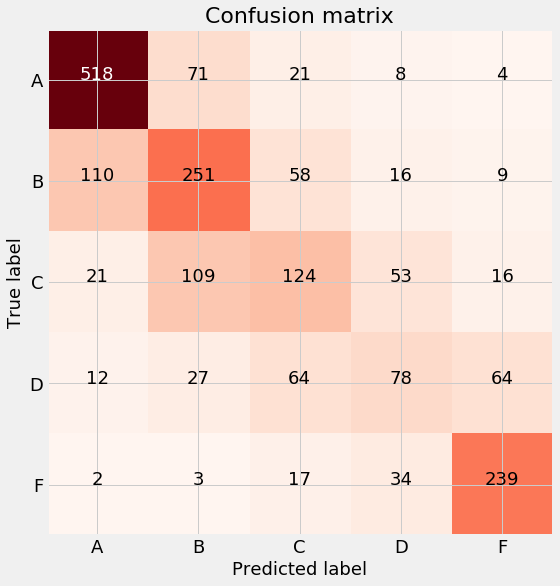

In [69]:
evaluate_clf(y_test,for_clf_pred)

From the given results the random forest classifier appears to do very well and can pretty accurately infer the energy score of a building.

And now we use our classifier to rank buildings with the missing energy score.

In [70]:
miss_clf_pred = for_clf.predict(miss_score_entries)

miss_clf_pred = pd.Series(miss_clf_pred).value_counts()
miss_clf_pred.sort_index()

A    761
B    443
C    247
D    173
F    480
dtype: int64

Any new building can now be classified by the model as long as it is provided with the appropriate data. We can be confident in the predictions of the model as shown by the high performance on the testing data.

### Conclusions

Based on the provided results, first thing we can conclude is that we can effectively use machine learning to predict (or classify) the energy score values. Since ESS is self-reported value, there's a lot of space for misscalculations and even cheating. We can also build a machine learning model to counter this, by predicting more correct ESS score for the value that seems suspicious.

We saw that electricity use intensity (EUI) natural gas and foil oil use, floor area and year the building was built make an impact on the energy star score. Moreover, EUI has quite high negative linear corellation with the energy score.

Another thing we noticed is that energy score varies across building types: offices and resident halls tend to have higher ESS than hotels and multi-family housings. Exploring this more in-dept could be a point of interest for the future work.
    

